<a href="https://colab.research.google.com/github/freentour/AIFFEL_quest/blob/main/Exploration_quest/Quest02/1_4_news_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# 1. 데이터 준비

In [2]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 구글 드라이브 경로
# /content/drive/MyDrive/AIFFEL/data/news_summarization/

## 1.1 불용어 사전 다운로드

In [3]:
# NLTK를 사용해 불용어 다운로드 받기
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 1.2 데이터 불러오기

In [ ]:
# import urllib.request
# urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

In [4]:
# 뉴스 데이터를 pandas 데이터프레임으로 불러오기
# filepath = "./data/news_summarization/news_summary_more.csv"
filepath = "/content/drive/MyDrive/AIFFEL/data/news_summarization/news_summary_more.csv"
data = pd.read_csv(filepath, encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [5]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


# 2. 데이터 전처리

In [6]:
# 기존 아마존 리뷰 관련해서 작성했던 코드를 그대로 사용하기 위해 컬럼 이름 변경하기
# headlines --> Summary, text --> Text
data.columns = ['Summary', 'Text']

In [7]:
data.head()

,Summary,Text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## 2.1 중복 제거

In [8]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
# 참고로, Summary 컬럼은 요약 내용이므로 당연히 중복이 있을 수 있음!
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [9]:
# [주의] Summary 컬럼은 당연히 중복이 있을 수 있음! (그래서, 아래에서 Text 컬럼만 중복 제거하는 것임)
# inplace=True 를 설정하면 새로운 DataFrame 타입 객체로 리턴하지 않고, 원본인 data 객체 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 2.2 NULL 제거

In [10]:
# NULL 확인
print(data.isnull().sum())

Summary    0
Text       0
dtype: int64


In [11]:
# # NULL 제거
# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 :', (len(data)))

## 2.3 종합적인 데이터 전처리 실시
- 대문자 --> 소문자로 변환
- HTML 태그 제거
- 괄호로 닫힌 문자열 모두 제거
- 쌍따옴표 제거
- 약어 정규화
  - 텍스트 데이터에 있어서 '약어 정규화 처리'는 영어 기준으로는 didn't --> did not 으로 일원화 시키는 것을 의미함.
  - 약어와 풀네임이 함께 사용된 경우 풀네임으로 일원화 하거나 약어로 일원화하거나 약어와 풀네임을 함께 사용하거나 등을 정해서 처리해도 될 듯.
- 소유격 제거
- 영어 외 문자 --> 공백(" ")으로 변환
- m이 3개 이상 사용되면 'mm' 으로 변환
- 불용어 제거
  - 여기에서는 Text 컬럼에 대해서는 불용어 제거, Summary 컬럼에 대해서는 불용어 제거하지 않음.

In [12]:
# 약어 정규화 준비
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [13]:
# 미리 다운받아 두었던 NLTK 불용어(stopwords) 사전 확인
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [18]:
# 문자열 좌우에 공백이 있는 데이터가 총 몇 개인지 확인해 보기
count_text = data['Text'].str.startswith(' ').sum() + data['Text'].str.endswith(' ').sum()
count_summary = data['Summary'].str.startswith(' ').sum() + data['Summary'].str.endswith(' ').sum()

print(f"Text 컬럼에서 좌우에 공백이 있는 데이터의 개수: {count_text}")
print(f"Summary 컬럼에서 좌우에 공백이 있는 데이터의 개수: {count_summary}")

Text 컬럼에서 좌우에 공백이 있는 데이터의 개수: 16441
Summary 컬럼에서 좌우에 공백이 있는 데이터의 개수: 2664


In [19]:
# 데이터 전처리 함수 정의
# 파라미터로 넘어오는 remove_stopwords 값을 기준으로 불용어 제거 여부를 결정.
# 여기에서는 Text 컬럼에 대해서는 불용어를 제거하고, Summary 컬럼에 대해서는 불용어 제거하지 않음.
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.strip() # [김주현 추가] 좌우 공백 제거
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text 컬럼)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary 컬럼)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [22]:
# 데이터 전처리 함수 테스트하기: 좌우 공백도 제거하는지 체크!
temp_text = '  Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = ' Great way to start (or finish) the day!!! '

print("text: ", "'" + preprocess_sentence(temp_text) + "'")
print("summary: ", "'" + preprocess_sentence(temp_summary, False) + "'")  # 불용어를 제거하지 않습니다.

text:  'everything bought great infact ordered twice third ordered wasfor mother father'
summary:  'great way to start the day'


In [23]:
# Text 컬럼 전체 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
clean_text = []

for sentence in data['Text']:
    processed_sentence = preprocess_sentence(sentence)
    clean_text.append(processed_sentence)

# # 아래처럼 map 함수 이용해서 처리해도 됨. (for 반복문에 비해 일반적으로 더 빠르게 처리됨) --> 실제로 해 보니 오히려 더 느렸음!(로컬 노트북 기준)
# data['Processed_Text'] = data['Text'].map(lambda x: preprocess_sentence(x))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [24]:
# # 아래처럼 map 함수 이용해서 처리해도 됨. (for 반복문에 비해 일반적으로 더 빠르게 처리됨)
# # => 실제로 해보니 무슨 이유에서인지 더 오래 걸림. (73분 정도 소요)
# processed_text = data['Text'].map(lambda x: preprocess_sentence(x))

In [25]:
# processed_text

In [26]:
len(clean_text)

98360

In [27]:
# 5개 샘플만 처리 결과 확인해 보기
for i in range(5):
    print(clean_text[i])

saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit
new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history
aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disabi

In [28]:
# Summary 컬럼 전체 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_summary = []

for sentence in data['Summary']:
    processed_sentence = preprocess_sentence(sentence, False)   # Summary 컬럼의 경우 불용어 제거하지 않음!
    clean_summary.append(processed_sentence)

# # 아래처럼 map 함수 이용해서 처리해도 됨. (for 반복문에 비해 일반적으로 더 빠르게 처리됨) --> 실제로 해 보니 오히려 더 느렸음!(로컬 노트북 기준)
# data['Processed_Summary'] = data['Summary'].map(lambda x: preprocess_sentence(x, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

<ipython-input-19-b06af0dceadd>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [29]:
len(clean_summary)

98360

In [30]:
# 5개 샘플만 처리 결과 확인해 보기
for i in range(5):
    print(clean_summary[i])

upgrad learner switches to career in ml al with salary hike
delhi techie wins free food from swiggy for one year on cred
new zealand end rohit sharma led india match winning streak
aegon life iterm insurance plan helps customers save tax
have known hirani for yrs what if metoo claims are not true sonam


In [31]:
# 전처리 결과를 원본 Series 객체로 업데이트
data['Text'] = clean_text
data['Summary'] = clean_summary

In [32]:
# [중요] 전처리 이후에는 원본 데이터에서 제거되는 것들이 많다보니 이전에 NULL 처리를 완료했더라도 전처리 이후에는 NULL 값이 새롭게 생길 수 있음!
# 빈 값을 Null 값으로 변환(아래에서 isnull() 메소드를 통해 간단히 처리하기 위해)
data.replace('', np.nan, inplace=True)

In [33]:
# 전처리 이후에 새롭게 생긴 NULL 데이터 확인
data.isnull().sum()

,0
Summary,0
Text,0


In [34]:
# # NULL 행 제거
# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 :', (len(data)))

## 2.4 데이터별 threshold 결정하고 처리하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


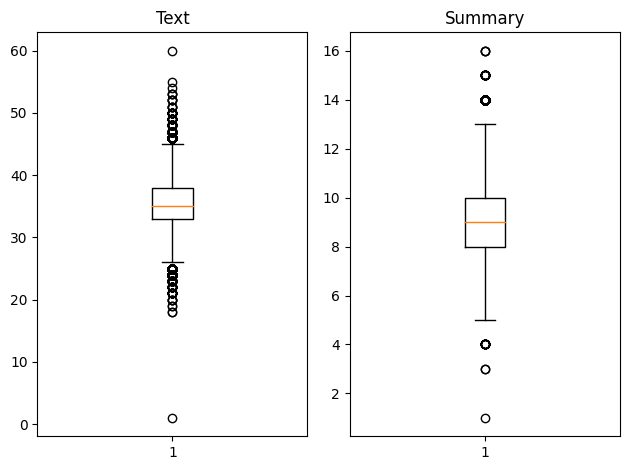

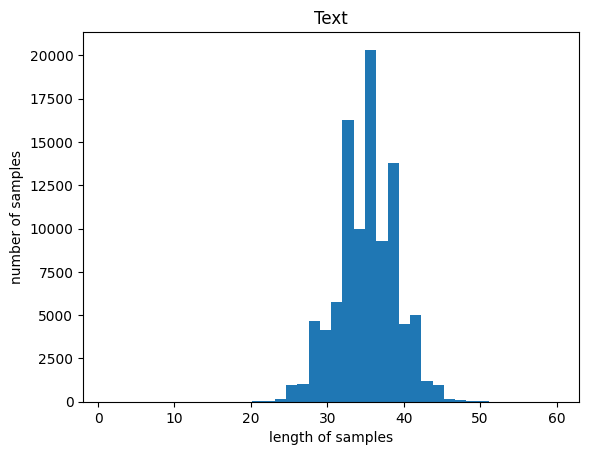

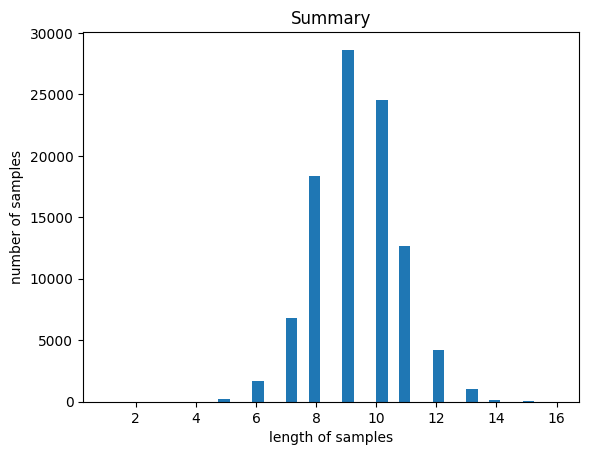

In [35]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [42]:
# 그래프를 보고 threshold 값을 임의로 정해 봄.
# 이번에는 데이터의 균형도 잘 잡혀있어서 전체 데이터를 모두 사용해보기로 함!
text_max_len = 60
summary_max_len = 16

In [43]:
# threshold 이하 샘플의 비율 계산 함수 정의:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [44]:
# Text, Summary 컬럼 전체에 대해 임의로 정한 threshold 이하인 샘플의 비율 확인
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [ ]:
# 이번에는 필터링 없이 전체 데이터셋 모두 사용하기로 함!!

# # 필터링 조건 적용: Text, Summary 컬럼에서 threshold 이하인 샘플들만 남기고, threshold 초과하는 샘플들은 모두 제거
# # [참고] 이러헥 하지 않고 threshold 초과하는 경우 초과하는 부분을 모두 삭제하되 샘플 자체는 유지하는 방법을 사용할 수도 있음.
# # 하지만, 여기에서는 원문과 요약문의 관계여서 원문에서 threshold 초과 부분을 제거한 상태로 학습하는게 의미가 없을거 같다고 판단해 아예 샘플에서 제거하는 방법을 택한 것 같음.
# data = data[
#     data['Text'].apply(lambda x: len(x.split()) <= text_max_len) &
#     data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)
# ]

# print('전체 샘플수 :', (len(data)))

# data

## 2.5 타겟 데이터 추가 작업
- [SOS] 토큰과 [EOS] 토큰 추가
- 디코더의 입력용으로 사용되는 데이터에는 [SOS] 토큰 추가
- 디코더의 출력 예측값에 대한 검증용 타겟 데이터(레이블 데이터)에는 [EOS] 토큰 추가

In [45]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


## 2.6 넘파이 배열로 변환

In [46]:
# 넘파이 배열로 변환
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [47]:
print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_target.shape)

(98360,)
(98360,)
(98360,)


## 2.7 데이터 섞기(셔플링)

In [48]:
# 데이터 섞기(셔플링) 위한 인덱스 번호 리스트 준비해 셔플링: 인덱스 번호만 셔플링된 상태임.
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[82123  3115 64689 ... 64796 35726 41660]


In [49]:
# 미리 셔플링해둔 indices 리스트를 활용해 실제 원본 데이터 리스트 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

## 2.8 훈련용, 검증용 데이터셋 분할
- [참고] 코드에서는 검증용 데이터셋을 계속 test 로 명명하고 있음.

In [50]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [51]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


## 2.9 토크나이징

### 2.9.1 인코더 입력용으로 들어가는 훈련용 데이터 토크나이징

In [52]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [60]:
# 등장 빈도수가 7회 미만인 단어들에 대한 여러가지 통계 정보 확인
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69650
등장 빈도가 6번 이하인 희귀 단어의 수: 47472
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22178
단어 집합에서 희귀 단어의 비율: 68.15793251974156
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4845483531854633


In [61]:
# 등장 빈도수가 7회 미만인 단어들은 제외해서 다시 한번 단어 집합 재생성
src_vocab = 20000    # 정확하게는 22,178개여야 하지만 대략 20,000개로 잡아 처리함.
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한(빈도수 기준으로 20,000등까지만 단어 집합에 포함됨)
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

### 2.9.2 정수 시퀀스로 변환

In [62]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
# [참고] 검증용 데이터셋(encoder_input_test) 역시 훈련용 데이터셋 기준으로 생성한 단어 집합으로 정수 시퀀스 변환함!
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[79, 1620, 81, 1484, 1929, 566, 14780, 2488, 196, 743, 33, 12198, 9683, 15, 1637, 4, 98, 1207, 2148, 256, 1637, 15, 1643, 19443, 1620, 1, 23, 2339, 2016, 4095, 886, 2611, 11591], [4006, 1866, 109, 2563, 4768, 2489, 149, 1450, 4007, 2303, 249, 6252, 4223, 1477, 557, 927, 4223, 3081, 310, 626, 326, 1507, 343, 188, 1450, 501, 4223, 556, 449, 4068, 16031, 2017, 590, 101], [206, 488, 290, 1716, 44, 5561, 1, 290, 103, 1071, 4926, 15352, 1071, 1176, 1, 121, 892, 799, 1005, 3301, 1119, 1071, 128, 445, 480]]


### 2.9.3 디코더 입력용으로 들어가는 훈련용 데이터 토크나이징

In [63]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)   # 단어 집합 생성

In [64]:
# Summary에 대해서는 등장 빈도수가 7 미만이 아니라 6 미만을 기준으로 처리: 임의로 정하는 것임
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30034
등장 빈도가 5번 이하인 희귀 단어의 수: 19630
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10404
단어 집합에서 희귀 단어의 비율: 65.35925950589332
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.6451421837499


In [65]:
tar_vocab = 10000    # 타겟 단어 집합은 10,000개로 제한
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)    # decoder_target_train 데이터에 대해서도 단어 집합에 추가!

### 2.9.4 정수 시퀀스로 변환

In [66]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 214, 493, 1941, 751, 1847, 7, 60, 277, 777], [1, 2890, 3594, 1914, 301, 144, 10, 900, 162, 2538], [1, 109, 24, 10, 145, 3, 550, 142, 2575, 85], [1, 576, 3, 226, 792, 1719, 14, 3020], [1, 1366, 10, 2576, 5, 859, 4, 229, 1814, 132, 85]]
target
decoder  [[214, 493, 1941, 751, 1847, 7, 60, 277, 777, 2], [2890, 3594, 1914, 301, 144, 10, 900, 162, 2538, 2], [109, 24, 10, 145, 3, 550, 142, 2575, 85, 2], [576, 3, 226, 792, 1719, 14, 3020, 2], [1366, 10, 2576, 5, 859, 4, 229, 1814, 132, 85, 2]]


### 2.9.5 최종적으로 스페셜 토큰만 남아있는 샘플 제거
- 단어 집합을 각각 20,000개와 10,000개로 줄인 상태에서 정수 시퀀스로 변환했기 때문에 빈도수가 낮은 단어들로만 이루어졌던 샘플 문장의 경우에는 정수 시퀀스 변환 이후에 스페셜 토큰([SOS] 또는 [EOS] 토큰)만 남아있게 될 수 있음.
- 따라서, 스페셜 토큰만 남아있어서 길이가 1인 샘플은 제거

In [67]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78687
훈련 레이블의 개수 : 78687
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


## 2.10 패딩 처리
- 데이터의 길이가 모두 동일할 수 있도록 패딩 처리

In [68]:
# 패딩 처리하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# 3. 모델 설계, 훈련, 추론

## 3.1 훈련용 모델 설계 및 훈련

### 3.1.1 인코더 설계

In [69]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
# [주의] 인코더 내 마지막 LSTM 셀이어서 출력 변수의 이름을 모두 숫자 없는 변수명으로 설정함!
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

### 3.1.2 디코더 설계

In [70]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
# [주의] 인코더의 마지막 셀에서 출력한 히든 스테이트, 셀 스테이트 값이 디코더의 초기 스테이트 값으로 사용됨!
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### 3.1.3 디코더의 출력층 설계

In [71]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

### 3.1.4 기본적인 seq2seq 모델 구조 전체 정의

In [72]:
# 모델 정의
# 전체 모델 입장에서는 입력으로 encoder_inputs, decoder_inputs 두개가 들어오고,
# 최종 출력으로 decoder_softmax_outputs가 나오는 구조인 것임.
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 60, 128)        │      2,560,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 60, 256),      │        394,240 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 60, 256),      │        525,312 │ lstm[0][0]             │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 128)      │      1,280,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 60, 256),      │        525,312 │ lstm_1[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 256),    │        394,240 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 10000)    │      2,570,000 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,249,104 (31.47 MB)

 Trainable params: 8,249,104 (31.47 MB)

 Non-trainable params: 0 (0.00 B)

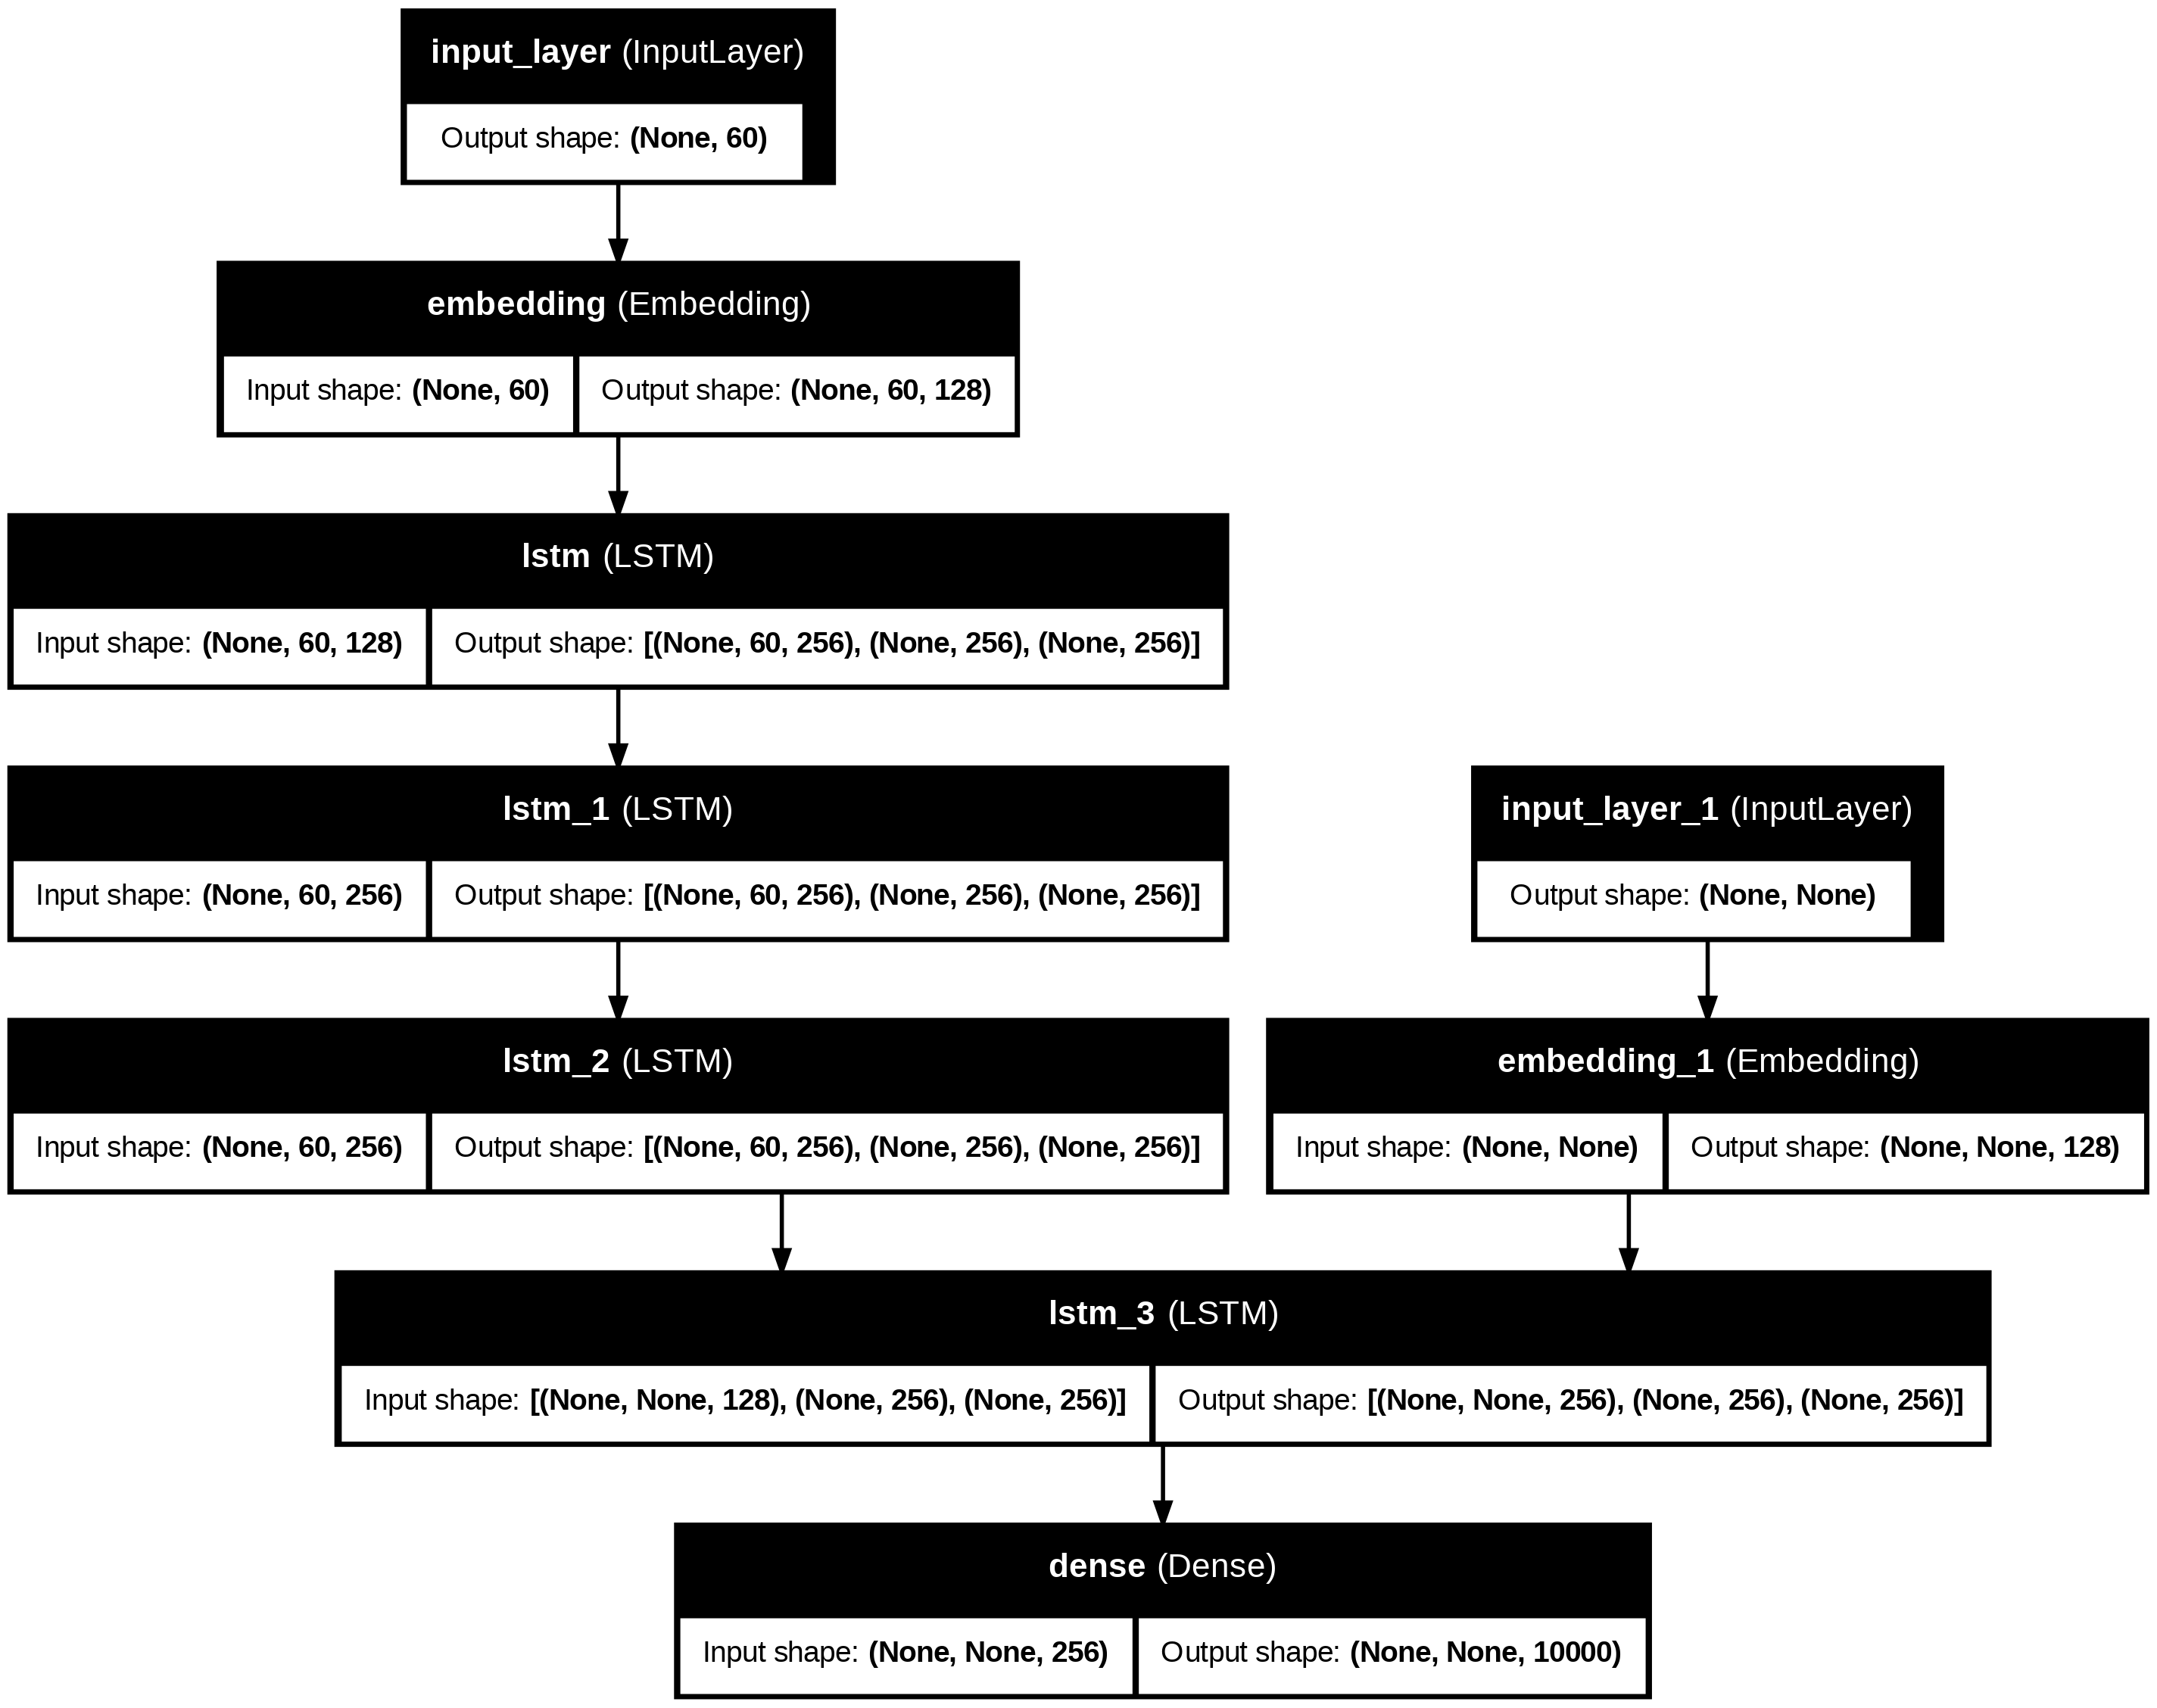

In [73]:
from tensorflow.keras.utils import plot_model

# 모델 구조를 그래프 형식으로 저장
# plot_model(model, to_file='./model_graph/seq2seq_base_model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model, to_file='/content/drive/MyDrive/AIFFEL/model_graph/seq2seq_base_model_plot.png', show_shapes=True, show_layer_names=True)

### 3.1.5 어텐션이 추가된 seq2seq with attention 구조로 모델 수정

In [74]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 60, 128)        │      2,560,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 60, 256),      │        394,240 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 60, 256),      │        525,312 │ lstm[0][0]             │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 128)      │      1,280,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 60, 256),      │        525,312 │ lstm_1[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 256),    │        394,240 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 256)      │            256 │ lstm_3[0][0],          │
│ (AdditiveAttention)       │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 512)      │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 10000)    │      5,130,000 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,809,360 (41.23 MB)

 Trainable params: 10,809,360 (41.23 MB)

 Non-trainable params: 0 (0.00 B)

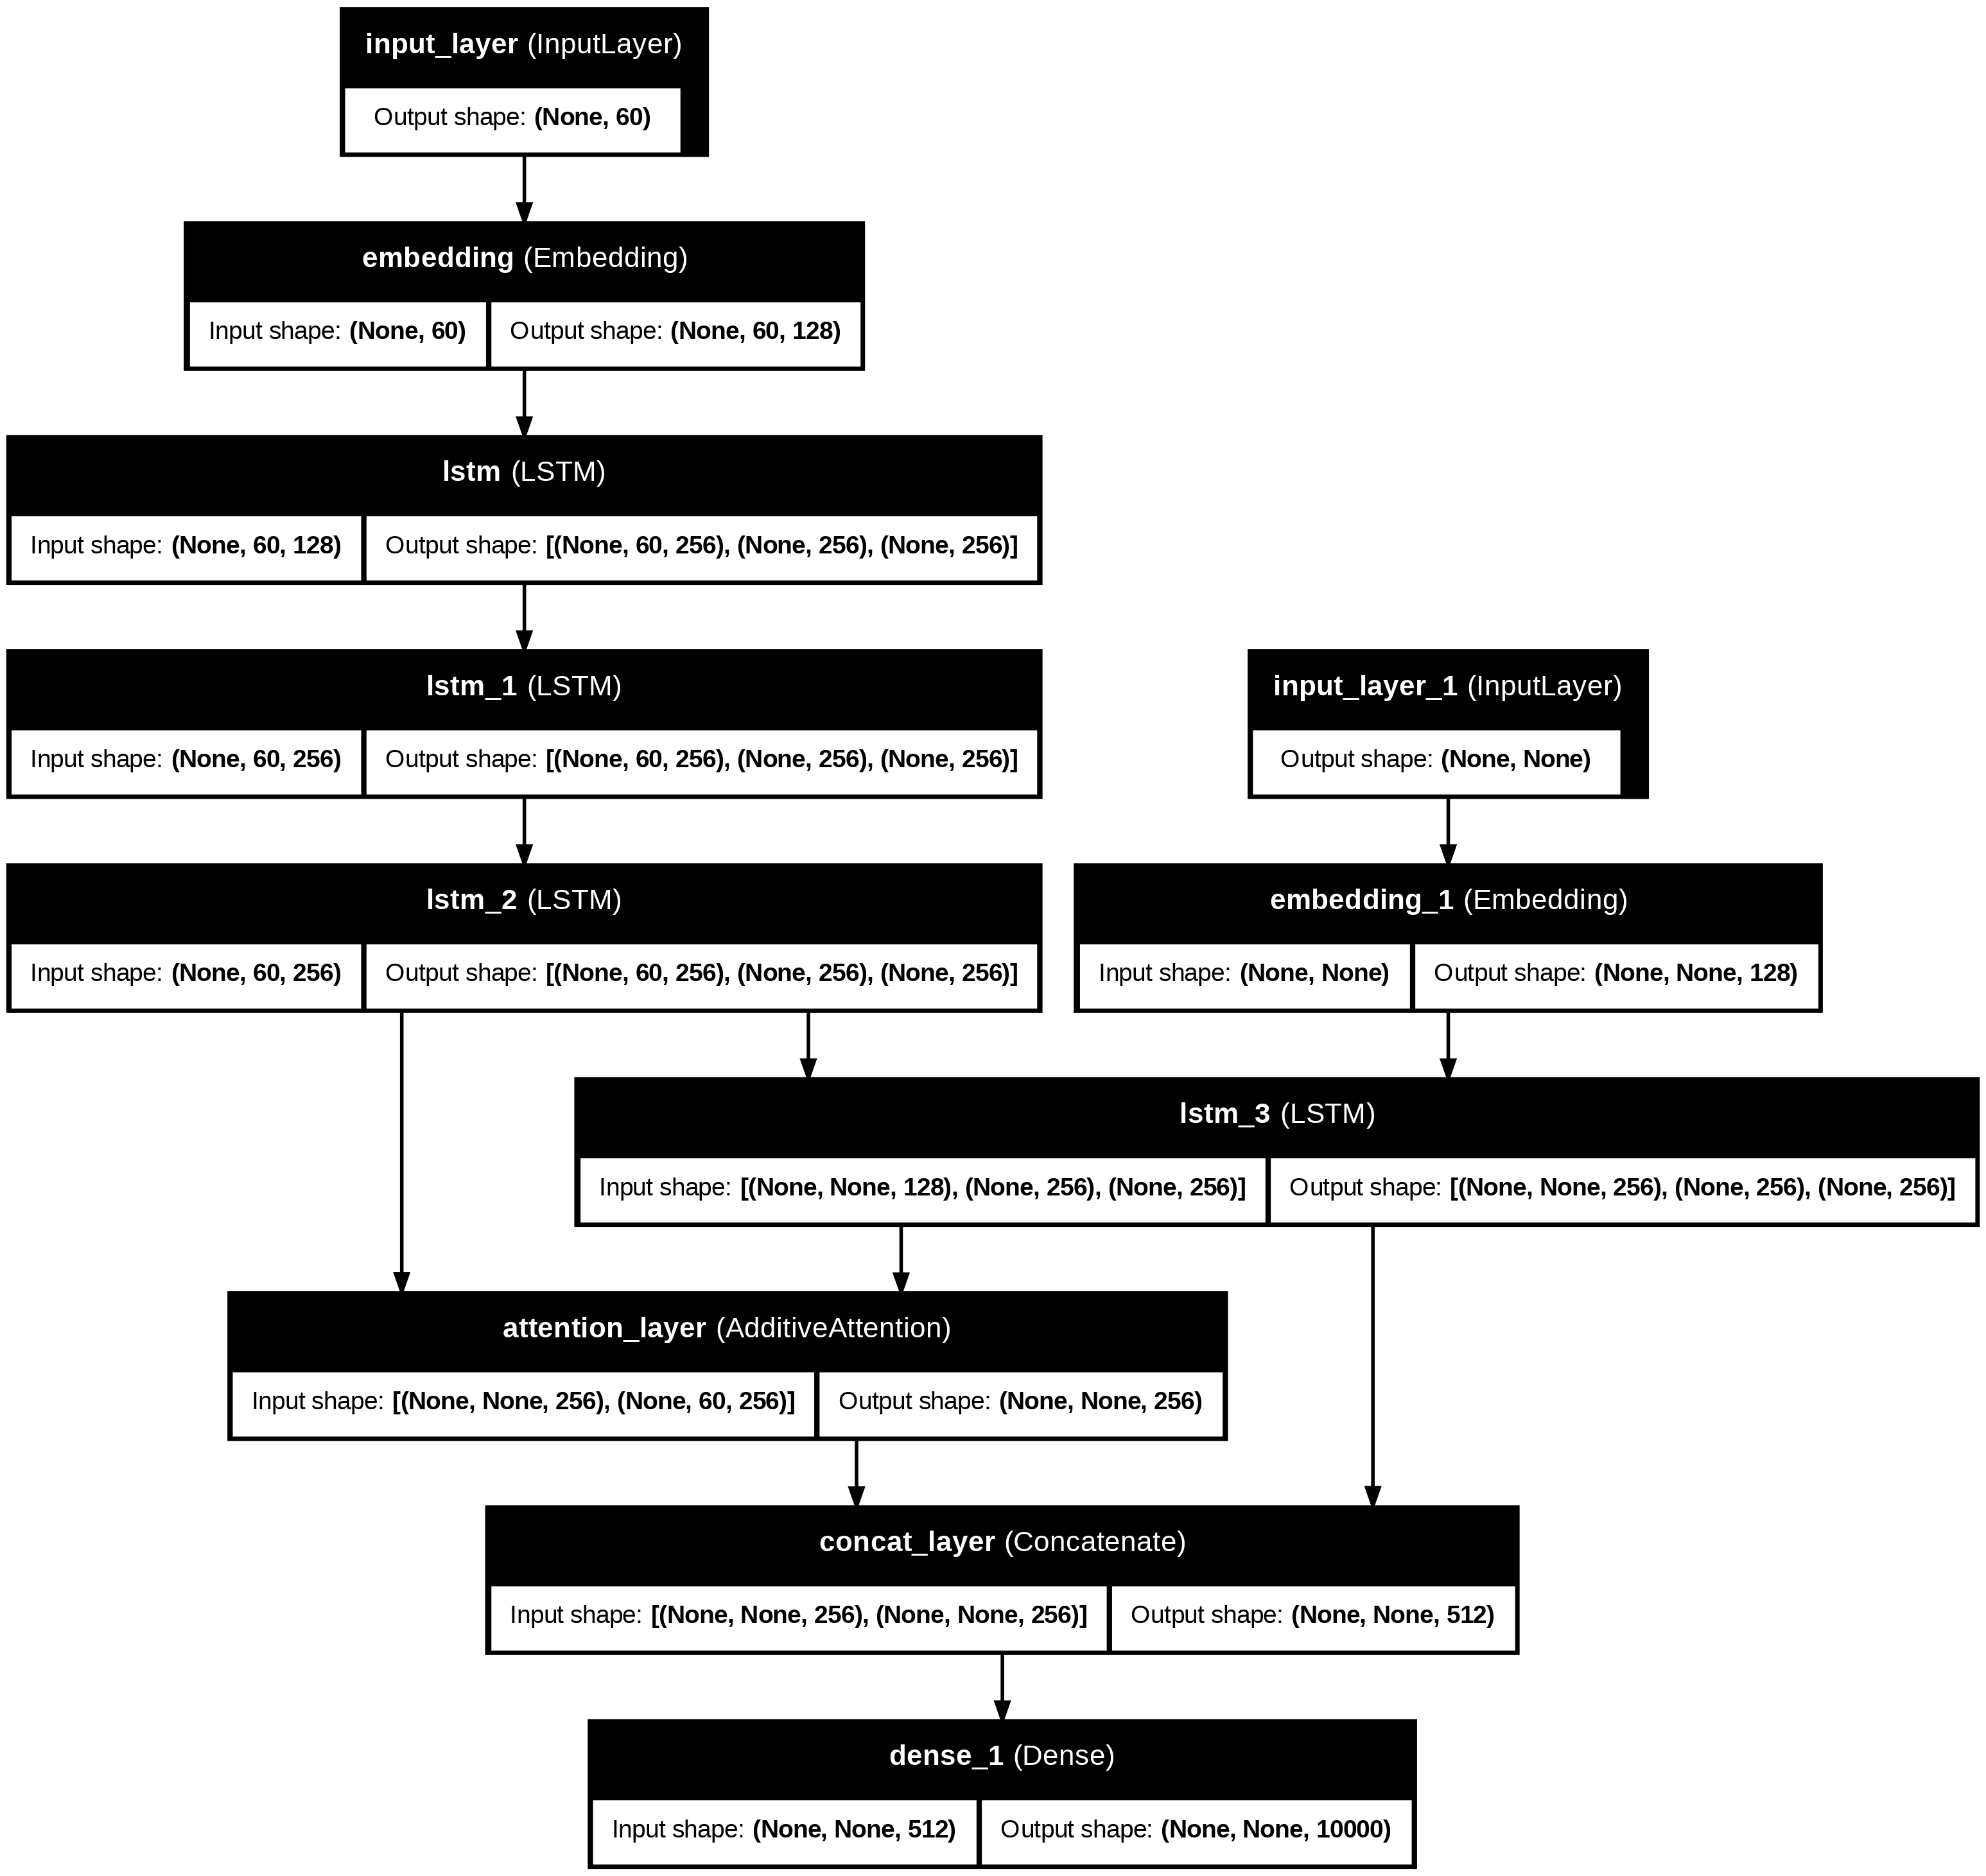

In [75]:
from tensorflow.keras.utils import plot_model

# 수정된 모델 구조를 그래프 형식으로 다시 저장
# plot_model(model, to_file='./model_graph/seq2seq_with_attention_model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model, to_file='/content/drive/MyDrive/AIFFEL/model_graph/seq2seq_with_attention_model_plot.png', show_shapes=True, show_layer_names=True)

### 3.1.6 모델 훈련하기

In [76]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# learning_rate를 적용하는 경우
# learning_rate = 0.0001    # 학습률 지정
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
#               loss=tf.keras.losses.sparse_categorical_crossentropy,
#               metrics=['accuracy'])   # Summarization 태스크의 경우 평가지표를 어떻게 설정해야할까? (BLEU 점수라는 것을 주로 활용한다고 함)

# 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    # filepath='./best_model/seq2seq_with_attention_best_model.keras',
    filepath='/content/drive/MyDrive/AIFFEL/best_model/seq2seq_with_attention_best_model.keras',
    monitor='val_loss',
    save_best_only=True)

BATCH_SIZE = 256
EPOCHS = 100

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping, model_checkpoint],
                    epochs=EPOCHS)

Epoch 1/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 124s 373ms/step - loss: 4.9671 - val_loss: 4.2285
Epoch 2/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 118s 382ms/step - loss: 4.2404 - val_loss: 4.1744
Epoch 3/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 143s 385ms/step - loss: 4.1722 - val_loss: 4.0784
Epoch 4/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 142s 385ms/step - loss: 4.0793 - val_loss: 3.9980
Epoch 5/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 142s 385ms/step - loss: 3.9878 - val_loss: 3.8992
Epoch 6/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 142s 385ms/step - loss: 3.8838 - val_loss: 3.8204
Epoch 7/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 142s 384ms/step - loss: 3.8061 - val_loss: 3.7702
Epoch 8/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 142s 385ms/step - loss: 3.7372 - val_loss: 3.7102
Epoch 9/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 118s 383ms/step - loss: 3.6732 - val_loss: 3.6576
Epoch 10/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 142s 384ms/step - loss: 3.6135 - val_loss: 3.6257
Epoch 11/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 142s 385ms/step - loss: 3.5580 - val_loss: 3.56

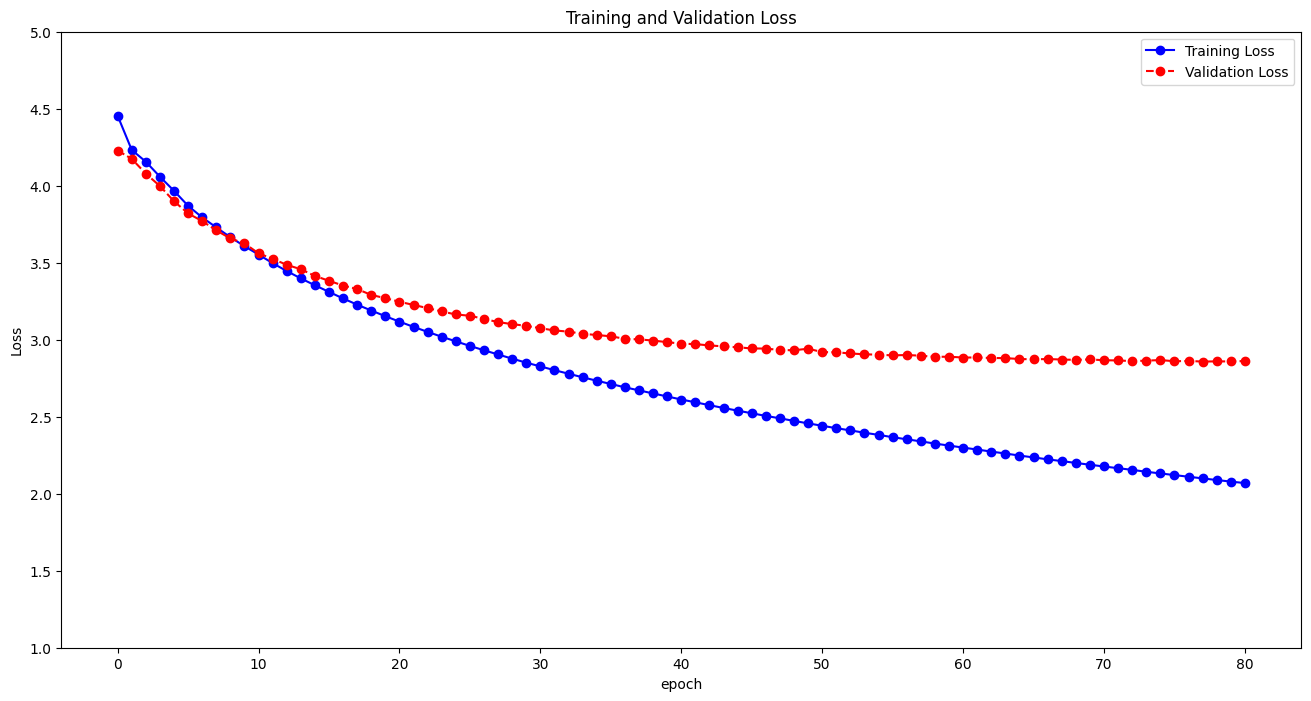

In [80]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
# plt.plot(acc, 'bo-', label='Training Accuracy')     # 대시선
# plt.plot(val_acc, 'ro--', label='Validation Accuracy')
# # plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')     # 대시선
# # plt.plot(epochs_range, val_acc, 'ro--', label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')
# plt.xlabel('epoch')

# plt.subplot(1, 2, 2)
plt.plot(loss, 'bo-', label='Training Loss')
plt.plot(val_loss, 'ro--', label='Validation Loss')
# plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
# plt.plot(epochs_range, val_loss, 'ro--', label='Validation Loss')
# plt.plot(val_loss, 'ro:', label='Validation Loss')    # 점선
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([1,5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 3.2 추론 모델 설계하기
- RNN 기반의 seq2seq 모델의 경우 훈련용 모델과 추론용 모델이 달라야 함.
- 훈련용 모델의 경우에는, 정답에 해당하는 decoder_inputs를 디코더의 입력으로 넣어줘서 설령 특정 타임스텝에서의 예측이 정답과 다른 경우라 하더라도 decoder_inputs에 포함된 정답이 매 타임스텝마다 새롭게 주어져서 계속 정답과 비교해 가면서 학습이 진행되어질 수 있음.
- 하지만, 추론용 모델의 경우에는, 정답에 해당하는 decoder_inputs를 디코더의 입력으로 넣어줄 수 없기 때문에 디코더의 매 타입스텝마다 예측한 결과값이(해당 결과값이 맞았든 틀렸든 상관없이) 다음 스텝의 디코더 입력값으로 주어지는 반복형 구조를 가질 수 밖에 없기 때문임.
- 따라서, 훈련용 모델의 경우 인코더와 디코더가 통합된 모델 하나로 정의할 수 있었지만, 추론용 모델의 경우에는 인코더와 디코더를 아예 분리해서 정의해 사용해야 함!

### 3.2.1 추론 단계(테스트 단계)에서 사용할 사전 미리 준비

In [81]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 3.2.2 추론용 인코더 설계

In [82]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

### 3.2.3 추론용 디코더 설계

In [83]:
# 바로 직전 타임스텝의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))   # 히든 스테이트용
decoder_state_input_c = Input(shape=(hidden_size,))   # 셀 스테이트용

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
# [참고] LMS의 원래 코드에서는 그냥 state_h2, state_c2 라고만 되어 있었는데, 앞에서 사용한 인코더 내 두 번째 LSTM의 출력값인 state_h2, state_c2와 구분하기 위해 변수명 앞에 dec_ 를 붙여 줌.
decoder_outputs2, dec_state_h2, dec_state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    # [참고] 여기에서도 LMS의 원래 코드에서는 그냥 state_h2, state_c2 였는데, 앞에서 변경한 변수명과 일치시키기 위해 변수명 앞에 dec_ 를 붙여줌.
    [decoder_outputs2] + [dec_state_h2, dec_state_c2])

### 3.2.4 모델 추론하기(테스트하기)

#### 3.2.4.1 추론용 단어 시퀀스 완성 함수 정의

In [84]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

#### 3.2.4.2 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 정의(원문용, 요약문용)

In [85]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + tar_index_to_word[i]+' '
    return temp

#### 3.2.4.3 추론하기(테스트하기)

In [86]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : ex windies batsman viv richards said loves virat kohli captaincy india like nice someone like virat love love give back cricket added indian team today team beat said 
실제 요약 : sostoken love kohli captaincy india now love to give it back richards 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
예측 요약 :  kohli is the of the world of kohli in aus


원문 : wrestler divya beat chen chinese taipei seconds hand india fourth bronze th medal overall edition asian games tuesday fighting kg category got lead within seconds six minute bout awarded victory technical 
실제 요약 : sostoken wrestler 

# 4. summa를 활용한 추출적 요약

In [88]:
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54389 sha256=5301ea77b69aa7429b888765b941e95d2a4f8e712692b50a9951c399b90da365
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [89]:
import requests
from summa.summarizer import summarize

In [97]:
temp_text = seq2text(encoder_input_test[50])
temp_text

'ex windies batsman viv richards said loves virat kohli captaincy india like nice someone like virat love love give back cricket added indian team today team beat said '

In [109]:
temp_text = "ex windies batsman viv richards said loves virat kohli captaincy india like nice someone like virat love love give back cricket added indian team today team beat said "

In [116]:
# summa의 경우 입력 문장이 충분히 길어야 요약문을 작성하는데, 입력으로 사용된 문장이 짧아서 summa가 요약문을 아예 생성하지 않는 것으로 보임!
print(summarize(temp_text, ratio=0.1))

In [117]:
# 훈련시킨 모델의 예측 요약 내용과 summa의 추출적 요약 내용 비교해서 보기
# summa의 경우 입력 문장이 충분히 길어야 요약문을 작성하는데, 입력으로 사용된 문장이 짧아서 summa가 요약문을 아예 생성하지 않는 것으로 보임!
for i in range(50, 100):
    original_text = seq2text(encoder_input_test[i])
    print("원문 :", original_text)
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("summa의 예측 요약 :", summarize(original_text, ratio=0.1))
    print("\n")

원문 : ex windies batsman viv richards said loves virat kohli captaincy india like nice someone like virat love love give back cricket added indian team today team beat said 
실제 요약 : sostoken love kohli captaincy india now love to give it back richards 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
예측 요약 :  kohli has the best in the world of kohli
summa의 예측 요약 : 


원문 : wrestler divya beat chen chinese taipei seconds hand india fourth bronze th medal overall edition asian games tuesday fighting kg category got lead within seconds six minute bout awarded victory technical 
실제 요약 : sostoken wrestler wins in to hand india its

In [99]:
# 매트릭스 시놉시스 다운로드
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [100]:
# 일부만 출력해 보기
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [101]:
# summa의 summarize 함수 파라미터 설명
"""
text (str) : 요약할 테스트.
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
words (int or None, optional) – 출력에 포함할 단어 수.
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환
"""
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [102]:
# 결과를 리스트로 받기
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [103]:
# 단어의 수로 요약문 크기 조절하기
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


# 5. 허깅페이스 모델 활용

## 5.1 Facebook의 BART 모델
- BART(Bidirectional and Auto-Regressive Transformers) : BART는 인코더-디코더 구조를 갖추고 있으며, 특히 요약 및 텍스트 생성 태스크에서 좋은 성능을 보이고 있다고 함.
- 참고로, BERT 모델은 인코더 구조만 갖추고 있음. (분류 태스크용으로 만들어진 거여서 인코더만으로 충분하기 때문)

In [118]:
from transformers import pipeline

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

ARTICLE = """ New York (CNN)When Liana Barrientos was 23 years old, she got married in Westchester County, New York.
A year later, she got married again in Westchester County, but to a different man and without divorcing her first husband.
Only 18 days after that marriage, she got hitched yet again. Then, Barrientos declared "I do" five more times, sometimes only within two weeks of each other.
In 2010, she married once more, this time in the Bronx. In an application for a marriage license, she stated it was her "first and only" marriage.
Barrientos, now 39, is facing two criminal counts of "offering a false instrument for filing in the first degree," referring to her false statements on the
2010 marriage license application, according to court documents.
Prosecutors said the marriages were part of an immigration scam.
On Friday, she pleaded not guilty at State Supreme Court in the Bronx, according to her attorney, Christopher Wright, who declined to comment further.
After leaving court, Barrientos was arrested and charged with theft of service and criminal trespass for allegedly sneaking into the New York subway through an emergency exit, said Detective
Annette Markowski, a police spokeswoman. In total, Barrientos has been married 10 times, with nine of her marriages occurring between 1999 and 2002.
All occurred either in Westchester County, Long Island, New Jersey or the Bronx. She is believed to still be married to four men, and at one time, she was married to eight men at once, prosecutors say.
Prosecutors said the immigration scam involved some of her husbands, who filed for permanent residence status shortly after the marriages.
Any divorces happened only after such filings were approved. It was unclear whether any of the men will be prosecuted.
The case was referred to the Bronx District Attorney\'s Office by Immigration and Customs Enforcement and the Department of Homeland Security\'s
Investigation Division. Seven of the men are from so-called "red-flagged" countries, including Egypt, Turkey, Georgia, Pakistan and Mali.
Her eighth husband, Rashid Rajput, was deported in 2006 to his native Pakistan after an investigation by the Joint Terrorism Task Force.
If convicted, Barrientos faces up to four years in prison.  Her next court appearance is scheduled for May 18.
"""
print(summarizer(ARTICLE, max_length=130, min_length=30, do_sample=False))
# >>> [{'summary_text': 'Liana Barrientos, 39, is charged with two counts of "offering a false instrument for filing in the first degree" In total, she has been married 10 times, with nine of her marriages occurring between 1999 and 2002. She is believed to still be married to four men.'}]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'summary_text': 'Liana Barrientos, 39, is charged with two counts of "offering a false instrument for filing in the first degree" In total, she has been married 10 times, with nine of her marriages occurring between 1999 and 2002. She is believed to still be married to four men.'}]


# 6. 참고자료

## 6.1 Tokenizer 객체의 주요 프로퍼티

In [119]:
src_tokenizer.word_index    # 딕셔너리 타입 {'단어': 인덱스 번호}

{'said': 1,
 'india': 2,
 'year': 3,
 'added': 4,
 'us': 5,
 'also': 6,
 'first': 7,
 'government': 8,
 'police': 9,
 'people': 10,
 'indian': 11,
 'old': 12,
 'two': 13,
 'minister': 14,
 'film': 15,
 'president': 16,
 'one': 17,
 'crore': 18,
 'world': 19,
 'court': 20,
 'state': 21,
 'years': 22,
 'would': 23,
 'reportedly': 24,
 'new': 25,
 'time': 26,
 'delhi': 27,
 'former': 28,
 'last': 29,
 'three': 30,
 'reports': 31,
 'company': 32,
 'earlier': 33,
 'like': 34,
 'based': 35,
 'congress': 36,
 'man': 37,
 'bjp': 38,
 'country': 39,
 'team': 40,
 'pakistan': 41,
 'claimed': 42,
 'day': 43,
 'chief': 44,
 'accused': 45,
 'modi': 46,
 'trump': 47,
 'singh': 48,
 'pm': 49,
 'women': 50,
 'allegedly': 51,
 'actor': 52,
 'million': 53,
 'party': 54,
 'according': 55,
 'made': 56,
 'pradesh': 57,
 'tuesday': 58,
 'friday': 59,
 'comes': 60,
 'lakh': 61,
 'wednesday': 62,
 'monday': 63,
 'woman': 64,
 'called': 65,
 'asked': 66,
 'around': 67,
 'video': 68,
 'thursday': 69,
 'khan': 7

In [120]:
src_tokenizer.index_word    # 딕셔너리 타입: {인덱스 번호: '단어'}

{1: 'said',
 2: 'india',
 3: 'year',
 4: 'added',
 5: 'us',
 6: 'also',
 7: 'first',
 8: 'government',
 9: 'police',
 10: 'people',
 11: 'indian',
 12: 'old',
 13: 'two',
 14: 'minister',
 15: 'film',
 16: 'president',
 17: 'one',
 18: 'crore',
 19: 'world',
 20: 'court',
 21: 'state',
 22: 'years',
 23: 'would',
 24: 'reportedly',
 25: 'new',
 26: 'time',
 27: 'delhi',
 28: 'former',
 29: 'last',
 30: 'three',
 31: 'reports',
 32: 'company',
 33: 'earlier',
 34: 'like',
 35: 'based',
 36: 'congress',
 37: 'man',
 38: 'bjp',
 39: 'country',
 40: 'team',
 41: 'pakistan',
 42: 'claimed',
 43: 'day',
 44: 'chief',
 45: 'accused',
 46: 'modi',
 47: 'trump',
 48: 'singh',
 49: 'pm',
 50: 'women',
 51: 'allegedly',
 52: 'actor',
 53: 'million',
 54: 'party',
 55: 'according',
 56: 'made',
 57: 'pradesh',
 58: 'tuesday',
 59: 'friday',
 60: 'comes',
 61: 'lakh',
 62: 'wednesday',
 63: 'monday',
 64: 'woman',
 65: 'called',
 66: 'asked',
 67: 'around',
 68: 'video',
 69: 'thursday',
 70: 'khan

In [121]:
src_tokenizer.word_counts   # OrderedDict 타입. ('단어', 빈도수) 형태의 튜플로 이루어진 리스트.

OrderedDict([('actress', 3166),
             ('sridevi', 323),
             ('revealed', 3125),
             ('changed', 354),
             ('clothes', 269),
             ('behind', 836),
             ('bushes', 14),
             ('trees', 201),
             ('even', 1768),
             ('bus', 665),
             ('earlier', 4775),
             ('vanity', 20),
             ('vans', 30),
             ('film', 7716),
             ('sets', 320),
             ('added', 14036),
             ('used', 2824),
             ('avoid', 437),
             ('drinking', 238),
             ('water', 1470),
             ('clean', 319),
             ('washrooms', 8),
             ('said', 43123),
             ('would', 5957),
             ('often', 215),
             ('fall', 257),
             ('sick', 109),
             ('shooting', 567),
             ('rain', 191),
             ('sequences', 22),
             ('wikileaks', 112),
             ('email', 280),
             ('media', 2586),
             

## 6.2 Tokenizer 객체 저장했다가 다시 로드해 사용하는 방법

In [122]:
# [샘플코드] Tokenizer 객체의 모든 정보를(설정 정보 포함해서 데이터까지) 저장해 두었다가, 다시 로드해 Tokenizer 객체 생성하기
# 특히, 모델 훈련 후 추론 과정에서 필요함.
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
import json

# 샘플 텍스트 데이터
texts = ["I love machine learning", "Deep learning is fun"]

# 토크나이저 생성 및 학습
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)

# 토크나이저 정보를 JSON 형태로 변환 및 저장
json_string = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    json.dump(json_string, f)

# 저장된 JSON 파일에서 토크나이저 로드
with open('tokenizer.json', 'r') as f:
    json_string = json.load(f)
loaded_tokenizer = tokenizer_from_json(json_string)

In [123]:
# 토크나이저의 설정 정보 뿐 아니라 사전 데이터까지 모든 정보가 JSON 형식으로 저장됨.
json_string

'{"class_name": "Tokenizer", "config": {"num_words": 10000, "filters": "!\\"#$%&()*+,-./:;<=>?@[\\\\]^_`{|}~\\t\\n", "lower": true, "split": " ", "char_level": false, "oov_token": null, "document_count": 2, "word_counts": "{\\"i\\": 1, \\"love\\": 1, \\"machine\\": 1, \\"learning\\": 2, \\"deep\\": 1, \\"is\\": 1, \\"fun\\": 1}", "word_docs": "{\\"i\\": 1, \\"learning\\": 2, \\"love\\": 1, \\"machine\\": 1, \\"is\\": 1, \\"deep\\": 1, \\"fun\\": 1}", "index_docs": "{\\"2\\": 1, \\"1\\": 2, \\"3\\": 1, \\"4\\": 1, \\"6\\": 1, \\"5\\": 1, \\"7\\": 1}", "index_word": "{\\"1\\": \\"learning\\", \\"2\\": \\"i\\", \\"3\\": \\"love\\", \\"4\\": \\"machine\\", \\"5\\": \\"deep\\", \\"6\\": \\"is\\", \\"7\\": \\"fun\\"}", "word_index": "{\\"learning\\": 1, \\"i\\": 2, \\"love\\": 3, \\"machine\\": 4, \\"deep\\": 5, \\"is\\": 6, \\"fun\\": 7}"}}'

In [124]:
# 로드된 토크나이저를 이용하여 새로운 텍스트를 정수 시퀀스로 변환
new_text = "Natural Language love Processing and Deep learning"
sequence = loaded_tokenizer.texts_to_sequences([new_text])
print(sequence)

[[3, 5, 1]]
